## Lyme Disease Image Classification

Given *images of various rashes*, let's try to predict if a given rash is a **symptom of Lyme disease**. 

We will use TensorFlow CNN to make our predictions.

Data source: https://www.kaggle.com/datasets/sshikamaru/lyme-disease-rashes

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

2025-06-10 12:29:26.795185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_dir = 'RashData/Train/Train_2_Cases'
val_dir = 'RashData/Validation/Validation_2_Cases'

In [3]:
batch_size = 32
img_height = 128
img_width = 128

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    subset='training',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    seed=42,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width)
)

Found 357 files belonging to 2 classes.
Using 286 files for training.
Found 357 files belonging to 2 classes.
Using 71 files for validation.
Found 87 files belonging to 2 classes.


2025-06-10 12:29:28.555420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Lyme_Negative', 'Lyme_Positive']


### Visualization

In [6]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels)

2025-06-10 12:29:28.722157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [286]
	 [[{{node Placeholder/_4}}]]
2025-06-10 12:29:28.722585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [286]
	 [[{{node Placeholder/_4}}]]
2025-06-10 12:29:28.797484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-06-10 12:29:28.855541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-06-10 12:29:29.011531: W tensor

(32, 128, 128, 3)
tf.Tensor([0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0], shape=(32,), dtype=int32)


2025-06-10 12:29:29.281014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


2025-06-10 12:29:29.369243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [286]
	 [[{{node Placeholder/_4}}]]
2025-06-10 12:29:29.371190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [286]
	 [[{{node Placeholder/_0}}]]
2025-06-10 12:29:29.435606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-06-10 12:29:29.489382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2025-06-10 12:29:29.628126: W tenso

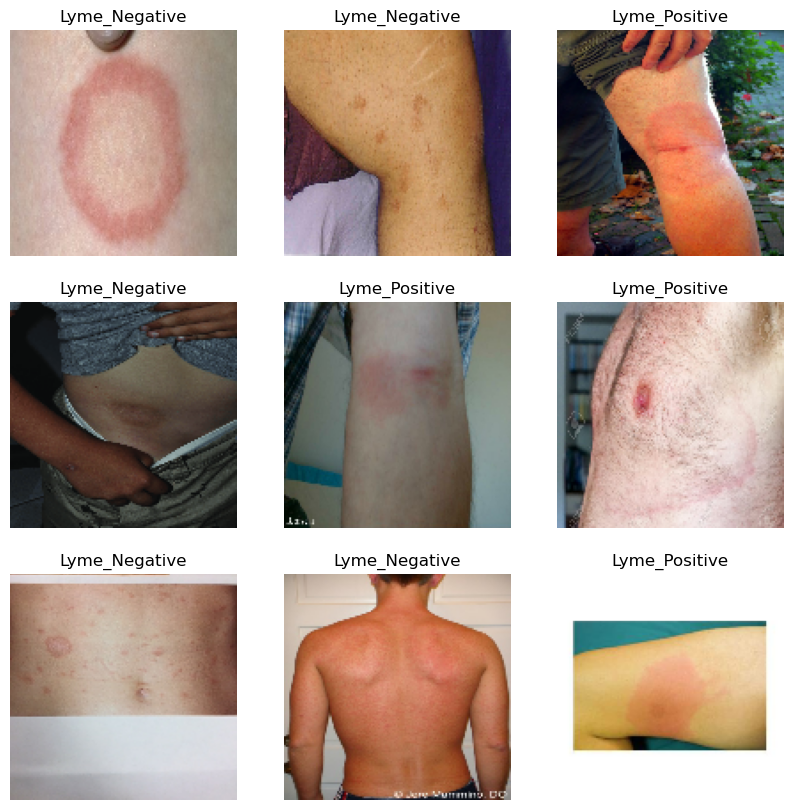

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

### Modeling

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

epochs = 76

history = model.fit(
    train_ds,
    validation_data = val_ds,
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/76
9/9 [==============================] - 6s 497ms/step - loss: 5.2214 - accuracy: 0.5490 - auc: 0.5152 - val_loss: 1.6889 - val_accuracy: 0.5493 - val_auc: 0.5405
Epoch 2/76
9/9 [==============================] - 4s 423ms/step - loss: 1.5057 - accuracy: 0.6818 - auc: 0.7377 - val_loss: 3.1950 - val_accuracy: 0.5493 - val_auc: 0.5489
Epoch 3/76
9/9 [==============================] - 3s 320ms/step - loss: 0.4971 - accuracy: 0.7063 - auc: 0.8283 - val_loss: 2.5842 - val_accuracy: 0.5493 - val_auc: 0.6114
Epoch 4/76
9/9 [==============================] - 3s 337ms/step - loss: 0.3898 - accuracy: 0.7552 - auc: 0.8867 - val_loss: 3.1471 - val_accuracy: 0.5493 - val_auc: 0.5677
Epoch 5/76
9/9 [==============================] - 3s 334ms/step - loss: 0.3324 - accuracy: 0.7972 - auc: 0.9147 - val_loss: 3.3337 - val_accuracy: 0.5493 - val_auc: 0.5865
Epoch 6/76
9/9 [==============================] - 4s 420ms/step - loss: 0.2701 - accuracy: 0.8601 - auc: 0.9516 - val_loss: 3.3152 - val_acc

### Results

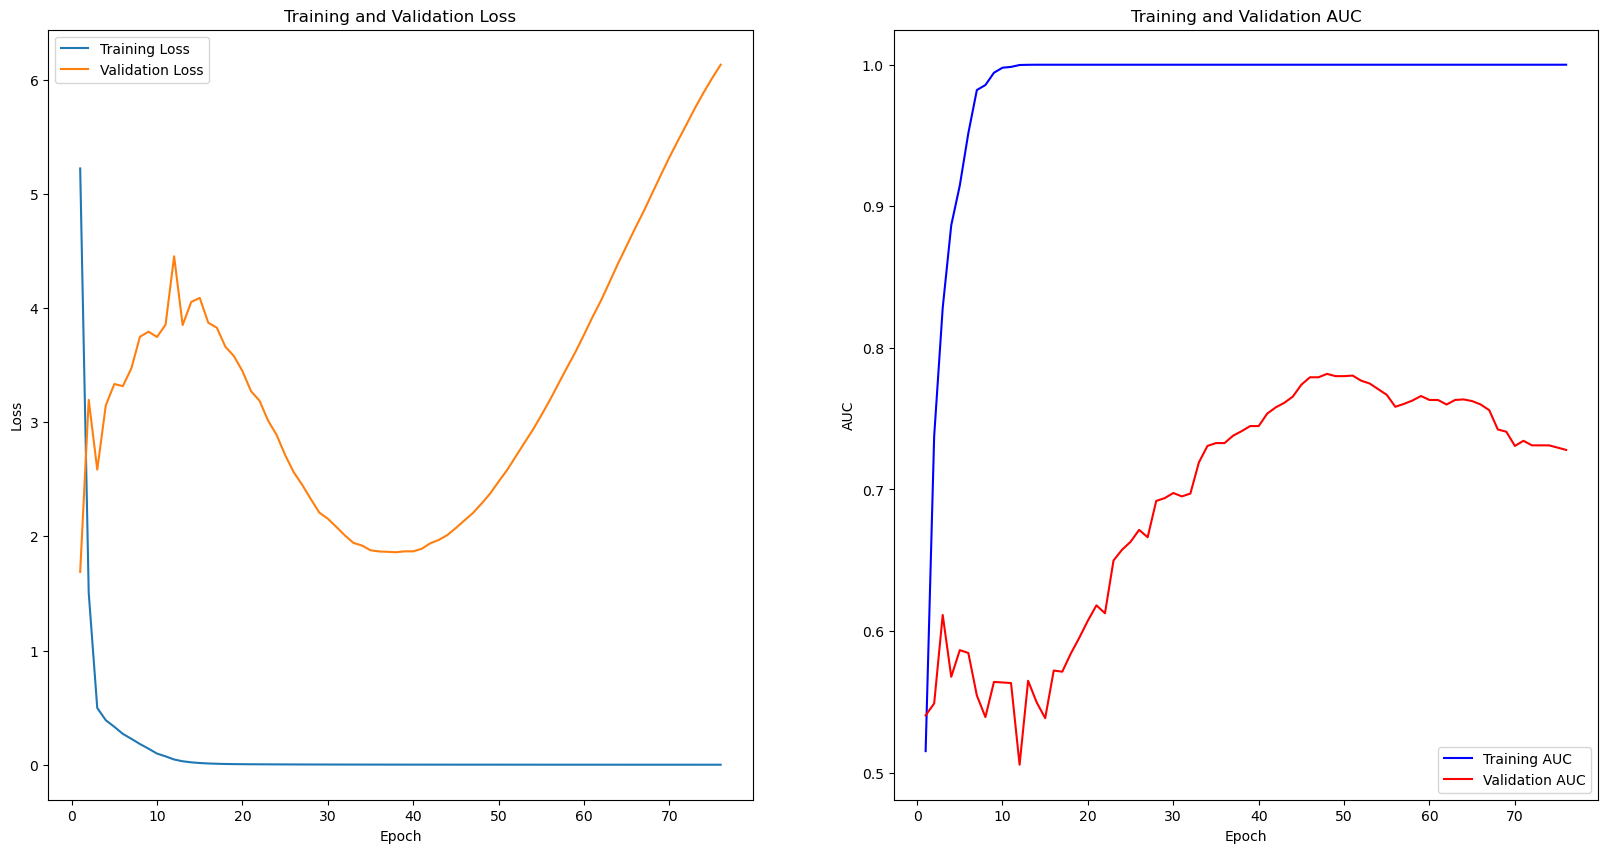

In [17]:
plt.figure(figsize=(20, 10))

epochs_range = range(1, epochs + 1)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_auc, label="Training AUC", color='b')
plt.plot(epochs_range, val_auc, label="Validation AUC", color='r')

plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Training and Validation AUC")
plt.legend()

plt.show()

In [18]:
model.evaluate(test_ds)

3/3 [==============================] - 1s 357ms/step - loss: 1.7985 - accuracy: 0.6782 - auc: 0.7862


[1.7985353469848633, 0.6781609058380127, 0.7862200140953064]

In [14]:
# np.argmin(val_loss)

7

In [15]:
# np.argmax(val_auc)

76